## **Neapykantos kalbos aptikimas**
### **Atliko:** Deividas Roščenkovas, Justas Komža, Paulius Martinkus

In [1]:
# !pip install --upgrade scikit-learn
# !python -m spacy download en_core_web_md
# !pip install scikit-learn==0.24
# !pip install seaborn
# !pip install wordcloud
# !pip install eli5
import eli5
from wordcloud import WordCloud
import spacy
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
from matplotlib import style    
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

style.use("ggplot")

nlp = spacy.load('en_core_web_md')

In [2]:
df = pd.read_csv("hatespeech_data.csv")
df.dropna(inplace=True)

In [3]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Pridedam papildomus nereikšmingus žodžius
nlp.Defaults.stop_words |= {"rt"}

In [4]:
def preprocess_with_punct(tweet):
    # kabučių panaikinimas
    tweet = re.sub(r'"', '', tweet)

    # šauktukų pradžioje panaikinimas
    tweet = re.sub(r'^!+', '', tweet)

    # vardų su @ panaikinimas
    tweet = re.sub(r'\B@\w+', '', tweet)

    # žodžių prasidedančių & panaikinimas
    tweet = re.sub(r'\B&\S+', '', tweet)

    # nuorodų panaikinimas
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',tweet)

    # nereikalingų tarpų panaikinimas
    tweet = re.sub(r'\s+',' ',tweet)

    return tweet

def preprocess_fully(tweet):
    # skaičių panaikinimas
    tweet = re.sub(r'\d+(\.\d+)?','', tweet)

    # Skyrybos ženklų panaikinimas 
    tweet_nopunct = re.sub(r'[^\w\s]',' ',tweet)
    tweet_nopunct = re.sub(r'\s+',' ',tweet_nopunct)
    
    doc = nlp(tweet_nopunct)
    lemmas = [ token.lemma_.lower().strip() for token in doc ]
    words = [ word for word in lemmas if word not in stop_words and word != '']
    return ' '.join(words)

def calc_punct(tweet):
    punct = re.findall(r'[.,!?]', tweet)
    return len(punct)


In [5]:
df['prep_punct_tweet'] = df['tweet'].apply(preprocess_with_punct)
df['punct'] = df['prep_punct_tweet'].apply(calc_punct)
df['tweet_length'] = df['prep_punct_tweet'].apply(len)
df['prep_tweet'] = df['prep_punct_tweet'].apply(preprocess_fully)

df["label"] = df["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate/Offensive"})
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,prep_punct_tweet,punct,tweet_length,prep_tweet,label
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT : As a woman you shouldn't complain about ...,4,118,woman shouldn t complain clean house man trash,No Hate/Offensive
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT : boy dats cold...tyga dwn bad for cuffin ...,5,72,boy dats cold tyga dwn bad cuffin dat hoe st p...,Offensive Language
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT Dawg!!!! RT : You ever fuck a bitch and sh...,5,85,dawg fuck bitch start cry confuse shit,Offensive Language
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT : she look like a tranny,0,28,look like tranny,Offensive Language
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT : The shit you hear about me might be true...,0,101,shit hear true faker bitch tell ya,Offensive Language


<Axes: xlabel='class', ylabel='punct'>

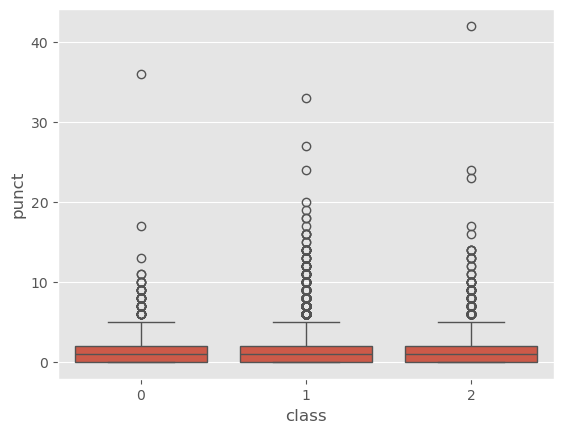

In [6]:
sns.boxplot(x='class', y='punct', data=df)

<Axes: xlabel='class', ylabel='tweet_length'>

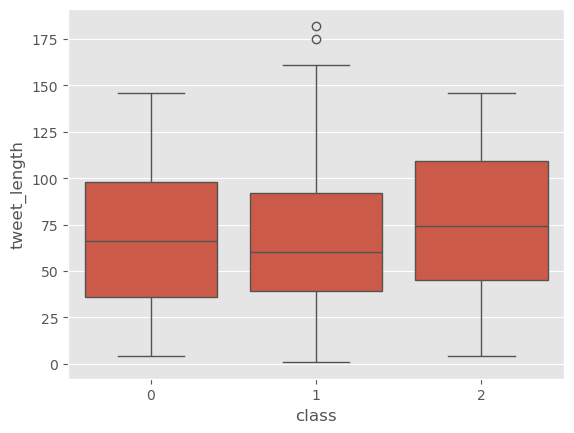

In [7]:
sns.boxplot(x='class', y='tweet_length', data=df)

C:\Users\ITWORK\AppData\Local\Temp\ipykernel_9944\2717403547.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


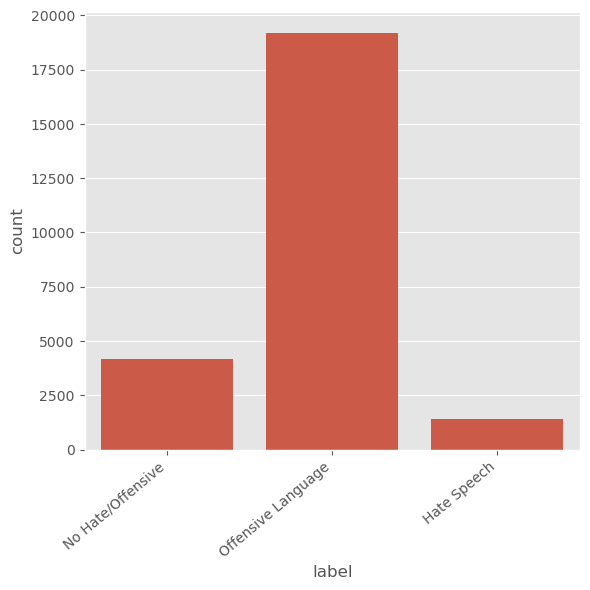

In [8]:
fig = plt.figure(figsize=(6,6))
ax = sns.countplot(x='label', data=df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_features=15000)
tfidf = tfidf_vectorizer.fit_transform(df['prep_tweet'])

In [32]:
from sklearn.model_selection import train_test_split

X = tfidf 
Y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X_train.shape)
print(X_test.shape)

(18587, 15000)
(6196, 15000)


In [33]:
#from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print(classification_report(Y_test, predictions))
print(f"Accuracy: {accuracy_score(Y_test, predictions)}")
print(f"Precision: {precision_score(Y_test, predictions, average='weighted')}")
print(f"Recall: {recall_score(Y_test, predictions, average='weighted')}")
print(f"F1: {f1_score(Y_test, predictions, average='weighted')}")

                    precision    recall  f1-score   support

       Hate Speech       0.60      0.20      0.30       346
 No Hate/Offensive       0.85      0.87      0.86      1020
Offensive Language       0.93      0.97      0.95      4830

          accuracy                           0.91      6196
         macro avg       0.79      0.68      0.70      6196
      weighted avg       0.90      0.91      0.90      6196

Accuracy: 0.907843770174306
Precision: 0.8961199928144575
Recall: 0.907843770174306
F1: 0.8960635503380231


In [35]:
eli5.show_weights(model,vec=tfidf_vectorizer,top=14)

In [36]:
eli5.show_prediction(model ,vec = tfidf_vectorizer,doc = 'damn lol Janay Rice speaks domestic violence costume mock marriage')

In [37]:
eli5.show_prediction(model ,vec = tfidf_vectorizer, doc = df['prep_tweet'][0])

In [38]:
eli5.show_prediction(model ,vec = tfidf_vectorizer, doc = "faggot here think address first name")

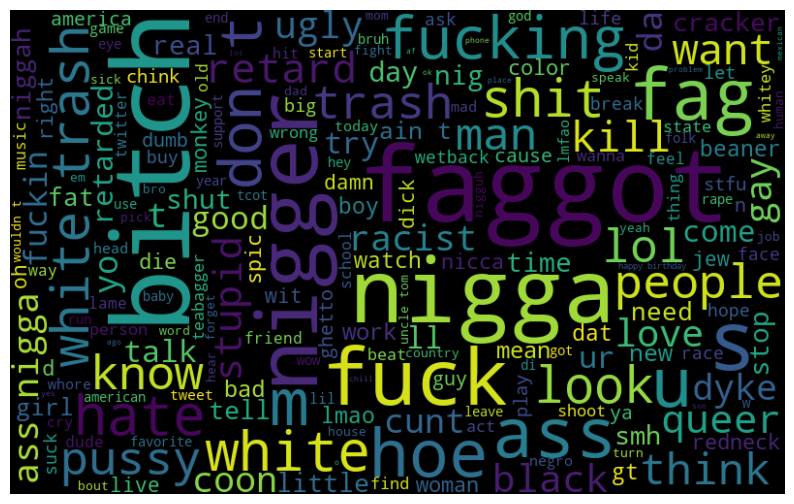

In [39]:
offensive_words = ' '.join([text for text in df['prep_tweet'][df['class'] == 0]])

wordcloud = WordCloud(width=800, height=500,
random_state=15, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

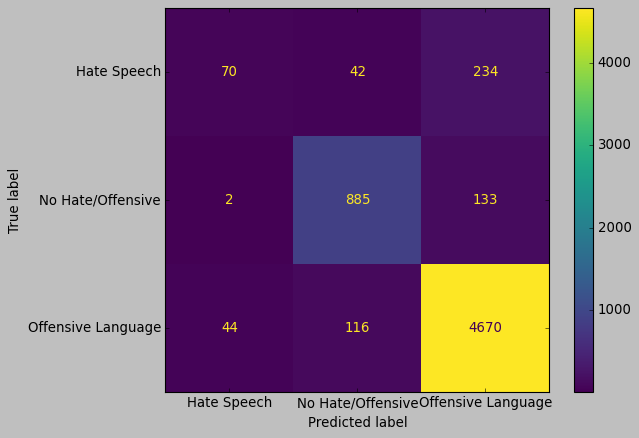

In [40]:
style.use('classic')
conf_matrix = confusion_matrix(Y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix , display_labels=model.classes_)
disp.plot()